In [1]:
import pandas
import numpy
import pylab
import ctm
import math

Dados de laço indutivo são os mais tradicionais para coletas de dados de tráfego e por décadas foi a única forma de coleta de dado automática por agências de tráfego. Mais recentemente tecnologias similares (magnetômetro) e distintas (câmeras) podem fornecem medias parecidas (contagem, ocupação e velocidade). No entanto, até a presente data os dados de laços indutivos são ainda prevalentes.

Independente disso, o método de processamento e análise são muito similares. Portanto, por agora vamos focar nos dados de laço provido pelo sistema California PeMS, mas pontuando potenciais diferenças para outras bases.

A figura abaixo mostra uma seção de dados brutos do California PeMS, basicamente cada registro contem:

- data (ano, mes, dia, hora, minuto, segundo)
- identificacoa do detector
- contagem para cada faixa
- ocupacao para cada faixa
- velocidade para cada faixa (não disponível em todas as estações)

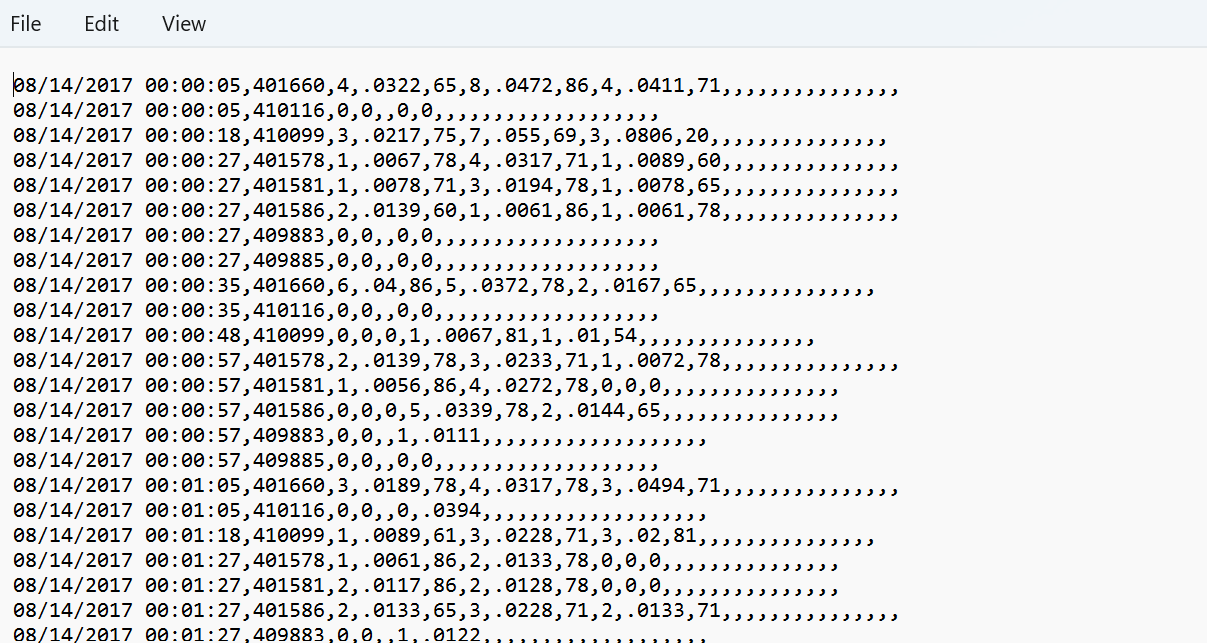

Os dados são basicamente esses podem mudar algums características:
- se é um detector por faixa, detector em uma das faixas ou o mesmo detector em todas as faixas
- a distribuição espacial deles (em rodovias é comum uma estação a cada certa distância, por exemplo)
- a frequência com que os dados são trasmitidos (a cada 30s, a cada minuto,...)

Os detectores podem possuir classificação de veículos. Aqui são os metadados dos dados disponívels próximo a Nashvhille (obtido pelo portal I24motion).

(metadados RD)

O processamento adequado permite fazer os gráficos como o abaixo:

(grafico PEMS)

In [2]:
MAXIMA_VELOCIDADE=100

def ler_dados_pems(caminho_arquivo):
    dados_por_detector = {} #vamos guardar os dados para cada detector separadamente.

    with open(caminho_arquivo, 'r') as f:
        for linha in f.readlines():
            dados_separados = linha.split(",")
            data = dados_separados[0]
            detector = dados_separados[1]
            
            contagens = []
            occs = []
            velocidades = []
            for u in range(4):
                contagem_str, ocup_str, velocidade_str = dados_separados[2+3*u:2+3*(u+1)]
                try:
                    contagem = int(contagem_str)
                    ocup = float(ocup_str)
                    try:
                        velocidade = float(velocidade_str)
                    except:
                        velocidade = None
                except:
                    #se nao conseguimos converter é porque nao existe mesmo
                    break
            
                contagens.append(contagem)
                occs.append(ocup)
                velocidades.append(velocidade)
            
            if detector not in dados_por_detector:
                dados_por_detector[detector] = []
            
            if sum(contagens) > 0 and None not in velocidades:
                v = sum(contagens)/sum([contagens[i]/velocidades[i] for i in range(len(velocidades)) if contagens[i] > 0 and velocidades[i] > 0])
                if v > 100:
                    v=100
            else:
                v=None

            dados_por_detector[detector].append({'data': data, 'detector': detector, 'contagens': contagens,
                                                 'occs': occs, 'velocidades': velocidades,
                                                 'occ_media': sum(occs)/len(occs), 'contagem_total': sum(contagens),
                                                 'vmedia':v})
    
    return dados_por_detector

def media_movel(serie, periodos):
    resultado = [0 for _ in range(len(serie))]
    for linha in range(periodos,len(serie)):
        porcao = serie[linha-periodos:linha]

        total = 0
        validos = 0
        
        for u, el in enumerate(porcao):
            if el is None:
                continue
            total = total + el
            validos +=1
        if validos > 0:
            resultado[linha] = total/validos
        elif validos==0 and resultado[linha] is not None:
            resultado[linha] = resultado[linha-1]
        else:
            resultado[linha] = None

    
    return resultado

Vamos ler os dados dos dias e vamos plotar as respectivas ocupacoes, contagens, e velocidades para cada detector para cada dia. 

Por enquanto estamos guardando os dados brutos em um dicionário, mas depois vamos vamos colocar em um DataFrame da biblioteca pandas.

In [3]:
datas = ['2017_08_14', '2017_08_15', '2017_08_16', '2017_08_17', '2017_08_18']

dados_pems_por_data = {}

for data in datas:
    dados_pems = ler_dados_pems(fr"C:\temp\pems\filtered_d04_text_station_raw_{data}.txt")
    dados_pems_por_data[data] = dados_pems
    f, axs = pylab.subplots(1,3, figsize=(12,4))
    for det_id in dados_pems:
        axs[1].plot(media_movel([record['contagem_total'] for record in dados_pems[det_id]],30), label=det_id)
        axs[0].plot(media_movel([record['occ_media'] for record in dados_pems[det_id]],30), label=det_id)
        axs[2].plot([record['vmedia'] for record in dados_pems[det_id]], label=det_id)
    
    f.suptitle(data)
    for i in range(3):
        axs[i].set_xlabel("Indice amostra")
    axs[1].set_xlabel("Indice amostra")

    axs[0].set_ylabel("Ocupacao media(-)")
    axs[1].set_ylabel("Contagem")
    axs[2].set_ylabel("Velocidade (mi/h)")
    axs[0].legend(fontsize=6)
    axs[1].legend(fontsize=6)
    pylab.tight_layout()
    pylab.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\temp\\pems\\filtered_d04_text_station_raw_2017_08_14.txt'

Os dados de laço indutivos tem essa grande vantagem para estudar um local específico, afinal:
- dados estão disponível por faixa em distâncias relativamente próximas
- vários locais tem históricos por longo periodos (+ de 20 anos) permitindo estudar padrões ou quando algo fora do padrão ocorre (incidentes) com uma grande base de dados
- há uma relação quase direto para entradas e saídas de modelos macroscópicos (contagem, densidade) e medidas agregadas (velocidade média, capacidade, etc.)   

Ao mesmo tempo, apresenta importantes limitações que tornam seu uso mais trabalhoso:
- laços indutivos podem parar de funcionar por diversos motivos
    - rompimento da fiação
    - recapeamento
    - degradação e perdas das propriedades magnéticas ou quebra do sistema eletrônico conectado ao laço responsável por processar os sinais.
- perda de comunicação com o equipamento de campo e a central recebendo os dados. (Vamos estudar mais a fundo um caso mais a frente que provavelmente ocorreu isso)

Aém disso, como todo medidor as suas medidas estão sujeito a erros:
- dupla contagem na mesma faixa: um veículo com uma distribuição massa tal que passa relativamente devagar pode ser identificado como dois veículos
- dupla contagem em faixas diferentes: o mesmo veículo pode ser identificado em faixas diferentes
- perda de contagem de veículos: motos são os casos clássicos, mas dependendo da posição e sensibilidade do laço pode também afetar um veículo pequeno

Para ter iuma ideia, vamos dar uma olhada mais a fundo no detector 401660 no dia 16 de junho de 2017.

In [ ]:
f, axs = pylab.subplots(1,2, figsize=(14,4))
axs[1].plot([record['contagem_total'] for record in dados_pems_por_data['2017_08_16']['401660']], label=det_id)
axs[0].plot([record['occ_media'] for record in dados_pems_por_data['2017_08_16']['401660']], label=det_id)
axs[0].set_xlabel("Indice amostra")
axs[1].set_xlabel("Indice Amostra")
axs[0].set_ylabel("Ocupacao")
axs[1].set_ylabel("Contagem por amostra")
pylab.show()

f, axs = pylab.subplots(1,2, figsize=(14,4))
axs[1].plot(range(1200, 1600), [record['contagem_total'] for record in dados_pems_por_data['2017_08_16']['401660']][1200:1600], label=det_id)
axs[0].plot(range(1200, 1600), [record['occ_media'] for record in dados_pems_por_data['2017_08_16']['401660']][1200:1600], label=det_id)
axs[0].set_xlabel("Indice amostra")
axs[1].set_xlabel("Indice Amostra")
axs[0].set_ylabel("Ocupacao")
axs[1].set_ylabel("Contagem por amostra")
pylab.show()

f, axs = pylab.subplots(1,2, figsize=(14,4))
axs[1].plot(range(1370, 1400), [record['contagem_total'] for record in dados_pems_por_data['2017_08_16']['401660']][1370:1400], label=det_id)
axs[0].plot(range(1370, 1400), [record['occ_media'] for record in dados_pems_por_data['2017_08_16']['401660']][1370:1400], label=det_id)
axs[0].set_xlabel("Indice amostra")
axs[1].set_xlabel("Indice Amostra")
axs[0].set_ylabel("Ocupacao")
axs[1].set_ylabel("Contagem por amostra")
pylab.show()

Veja que os dados ficaram zeradas por aproximadmente 10 amostras (5 minutos). Pode-se afirmar que não é nada demais. Para a boa parte das aplicações isto pode não ser nada demais.

No entanto, a norma é sempre ter algum erro e muito dos erros não são perceptíveis. Por exemplo, uma faixa com um laço menos sensível pode perder 50% dos carros e em um local de 3 faixas isso seria 17 por cento de erro.

Para se ter uma ideia, o PeMS mantem uma nota de desempenho do sistema que dificilmente passa dos 70% (veja abaixo).

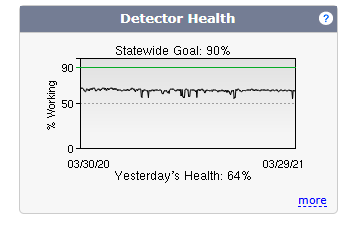

Por esse motivo, um passo essencial para tratar deste tipo de dado é o pré-processamento e a inputação de dados.

Na sequencia vamos:
- carregar os dados e colocá-los em DataFrames pandas
- utilizar a técnica de média de correção por média móvel para corrigir ocupação e contagem
- utilizar a técnica de estimativa por regressão para corrigir ocupação e contagem.

In [ ]:
#primeiro passo é manter todos os dados em uma única estrutura de dados
registros = []
for data in datas:
    dados_pems = ler_dados_pems(fr"C:\temp\pems\filtered_d04_text_station_raw_{data}.txt")
    for det_id in dados_pems:
        registros.extend(dados_pems[det_id])

print("total de registros", len(registros))
for i in range(6):
    print(registros[i])

agora vamos preparar os dados. No pandas não podemos ter listas então vamos fazer colunas como c_1, c_2,..., CN. O número de colunas independe do detector portanto vamos identificar a seção com maior número de detectores e fazer novos registros.

Da mesma forma, vamos processar o campo data com colunas para ano, mes, dia, hora, minuto, segundo o que vai facilitar o nosso processamento.

In [ ]:
def obter_campos_de_data(string_data):
    data, hora = string_data.split(' ')
    mes_str, dia_str, ano_str = data.split('/')
    hora_str, minuto_str, segundo_str = hora.split(':')

    return {'ano': int(ano_str), 'mes': int(mes_str), 'dia': int(dia_str),
            'hora': int(hora_str), 'minuto': int(minuto_str), 'segundo': int(segundo_str)}

max_dets = max([len(registro['contagens']) for registro in registros] )
print(obter_campos_de_data('08/14/2017 00:00:05'))
print("maximo detectores", max_dets)


Sabemos processar o campo de data e sabemos que teremos 3 detectores então nossos registros tem que ter contagem_1, contagem_2, contagem_3, occ_1,...

vamos convertê-los de forma que podemos criar um dataFrame depois

In [ ]:
def cria_registro_vazio():
    return {'ano': None, 'mes': None, 'dia': None, 'hora': None, 'minuto': None, 'segundo': None, 
            'detector': None,
            'contagem_1': None, 'contagem_2': None, 'contagem_3': None, 
            'occ_1': None, 'occ_2': None, 'occ_3': None,
            'vel_1': None, 'vel_2': None, 'vel_3': None,
            'contagem_total': None, 'contagem_total_corrigida': None,
            'occ_media': None, 'occ_media_corrigida': None,
            'vmedia': None}


registros_panda = []
for registro in registros:
    registro_panda = cria_registro_vazio()
    registro_panda['detector'] = registro['detector']
    informacao_data = obter_campos_de_data(registro['data'])
    for k,v in informacao_data.items(): #sobrescreve a informacao da data corretamente
        registro_panda[k] = v
    
    for i in range(len(registro['contagens'])):
        registro_panda[f"contagem_{i+1}"] = registro['contagens'][i]
        registro_panda[f"occ_{i+1}"] = registro['occs'][i]
        registro_panda[f"vel_{i+1}"] = registro['velocidades'][i]
    

    registro_panda['occ_media'] = registro['occ_media']
    registro_panda['contagem_total'] = registro['contagem_total']
    registro_panda['vmedia'] = registro['vmedia']

    registros_panda.append(registro_panda)

df_pems = pandas.DataFrame.from_records(registros_panda)
print(df_pems)

In [ ]:
#vamos "brincar" um pouco e analisar e tirar um relatório clássico que seria o total de contagem por hora

df_group = df_pems[['detector', 'hora',"contagem_total", "occ_media"]].groupby(['detector', 'hora']).mean()

dados_por_detector = {}

for idx, row in df_group.iterrows():
    detector, hora = idx
    if detector not in dados_por_detector:
        dados_por_detector[detector] = {'horas': [], 'contagens':[], 'occ_media': []}
    
    dados_por_detector[detector]['horas'].append(hora)
    dados_por_detector[detector]['contagens'].append(120*row['contagem_total'])
    dados_por_detector[detector]['occ_media'].append(row['occ_media'])


f, axs = pylab.subplots(1,2, figsize=(8,4))
for det_id in dados_por_detector:
    axs[0].plot(dados_por_detector[det_id]['horas'], dados_por_detector[det_id]['contagens'], label=det_id)
    axs[1].plot(dados_por_detector[det_id]['horas'], dados_por_detector[det_id]['occ_media'], label=det_id)
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Hora do dia (h)")
axs[1].set_xlabel("Hora do dia (h)")
axs[0].set_ylabel("Fluxo horário (veh)")
axs[1].set_ylabel("Ocupacao media")
pylab.tight_layout()
pylab.show()



Este exemplo já nos ajuda a entender um pouco como funciona essa região. Qual é o gargalo crítico e em que hora do dia.

Vamos voltar ao caso do detector que possuía entradas zeradas e tentar estimar estas entradas. Vamos trabalhar com um dataframe só daquele detector para analisá-lo.

In [ ]:
df = df_pems[df_pems['detector']=='401660'].reset_index()
print(df)

In [ ]:
#vamos agora ao primeiro método que é inserindo a média móvel corrente quando o dado parece ser problemático.
dados = df[df['dia']==16]['contagem_total'].to_numpy()
occ = df[df['dia']==16]['occ_media'].to_numpy()
media_movel_contagens = media_movel(dados, 10) #media movel de 5 minutos.
occ_media_movel = media_movel(occ, 10) #media movel de 5 minutos.
diff = media_movel_contagens-dados
DESV_CONTAGEM = diff.std()
print("desvio padrao", diff.std(), "differenca media", diff.mean())
pylab.hist(diff)
pylab.show()

diff_occ = occ_media_movel-occ
pylab.hist(diff_occ)
DESV_OCC = diff_occ.std()
print("desvio padrao occ", diff_occ.std(), "differenca media", diff_occ.mean())
pylab.show()

As formais mais simples de inputação de dados é detectar amostras fora do padrão por regras que em geral olham para amostras muito longe do desvio padrão.

Aqui só estamos olhando a média móvel, mas é comum utilizar os dados históricos (por detector, por hora, por dia da semana, etc.) para esta inputação. Aqui estamos usando uma regra bem simples no entanto.

Abaixo definimos um fator sobre o desvio padrão e se as contagens e ocupações diferirem mais que esse fator multiplicado do desvio padrão então corrigimos pela própria média móvel.

In [ ]:
JANELA = 10
f_dev = 3

corrigido = [el for el in dados[0:JANELA]]
occ_media_movel_corrigida = [el for el in occ[0:JANELA]]

original_corrigidos = []
valor_corrigidos = []
for i in range(JANELA,dados.shape[0]):
    media_movel_atual = sum(corrigido[-JANELA:])/JANELA
    occ_movel = sum(occ_media_movel_corrigida[-JANELA:])/JANELA
    if (abs(dados[i]-media_movel_atual) > f_dev*DESV_CONTAGEM and (abs(occ_movel-occ[i]) > f_dev*DESV_OCC)):
        corrigido.append(media_movel_contagens[i])
        original_corrigidos.append(dados[i])
        valor_corrigidos.append(corrigido[-1])
        occ_media_movel_corrigida.append(occ_media_movel_corrigida[-1])
    else:
        corrigido.append(dados[i])
        occ_media_movel_corrigida.append(occ[i])

f, axs = pylab.subplots(1,4, figsize=(18,4))

axs[0].plot(dados)
axs[0].set_ylabel("Contagem original")
axs[1].plot(corrigido)
axs[1].set_ylabel("Contagem corrigida")
axs[2].plot([corrigido[i]-dados[i] for i in range(len(dados))])
axs[2].set_ylabel("Magnitude da correção")
axs[3].scatter(dados, corrigido, label='Todos')
axs[3].set_ylabel("Valor corrigido")
axs[3].set_xlabel("original")
axs[3].scatter(original_corrigidos, valor_corrigidos, label='Corr')
axs[3].legend()
pylab.tight_layout()
pylab.show()

f, axs = pylab.subplots(1, figsize=(12,4))
axs.plot(range(1100, 1800), dados[1100:1800], label='original')
axs.plot(range(1100, 1800), corrigido[1100:1800], label='corridigo')
axs.set_xlabel("Indice amostra")
axs.set_ylabel("Contagem")
axs.legend()
pylab.tight_layout()
pylab.show()

Focamos aqui no último gráfico no período que sabíamos que a série estava zerada e portanto aparentemente errônea. 

Nos 3 grupos de amostras em zero houve correção e no resto os dados se mantiveram, mas está claro que quando foram múltiplas amostras zeradas a correção foi parcial.

Vamos utilizar uma outra abordagem que utiliza a mesma ideia de olhar os dados próximos, mas tenta fazer uma busca mais "educada" através de regresão linear

In [ ]:
#agora para esse mesmo detector, vamos tentar relacionar o valor no indice t com os valores observados no índice t-1, t-2, e podemos incluir passos a frente (t+1, t+2, ...)
JANELA = 20
contagens_observadas = df['contagem_total'].to_numpy()

def cria_vetor_relacionados(janela, vetor):
    vetor_relacionados = numpy.zeros((vetor.shape[0], 2*janela))

    for u in range(1,JANELA+1):
        vetor_relacionados[:,u-1] = numpy.roll(vetor,u)
        vetor_relacionados[:,janela-1+u] = numpy.roll(vetor,-u)
    return vetor_relacionados

vetor_relacionados = cria_vetor_relacionados(JANELA, contagens_observadas)
valores = numpy.linalg.lstsq(vetor_relacionados, contagens_observadas)
pylab.plot(valores[0], '-*')
pylab.show()
print(sum(valores[0]))

#aqui as predicoes sem nenhuma técnica em particular
predicao = vetor_relacionados@valores[0]
pylab.scatter(contagens_observadas, predicao)
pylab.show()

df['contagem_total_corrigida'] = predicao

df_16 = df[df['dia']==16].reset_index()
observadas = df_16['contagem_total'].to_numpy()
corrigidas = df_16['contagem_total_corrigida'].to_numpy()

pylab.plot(observadas[1100:1600])
pylab.plot(corrigidas[1100:1600])
pylab.show()


Veja que a correção ficou no "meio do caminho" porque os passos futuros eram zerados e acabou enviezando o resultado. No entanto podemos aplicar a predicao sobre os dados múltiplas vezes para eliminar este efeito.

No exemplo abaixo, é mostrado os resultado para 10 "re-aplicações".

In [ ]:
for t in range(10):
    vetor_relacionados = cria_vetor_relacionados(JANELA, predicao)
    predicao = vetor_relacionados@valores[0]


df['auxiliar_correcao'] = predicao #como aplicamos isso sobre os 5 dias, vamos deixar auxiliar por enquanto e corrigir por uma regra simples.
df_16 = df[df['dia']==16].reset_index()

dados = df_16['contagem_total'].to_numpy()
predicao_corrigida = df_16['auxiliar_correcao'].to_numpy()

original_corrigidos = []
valor_corrigidos = []
corrigido = []
f_dev = 3
for i in range(dados.shape[0]):
    if abs(dados[i]-predicao_corrigida[i]) > f_dev*DESV_CONTAGEM and (abs(dados[i]-predicao_corrigida[i]))/max(((dados[i],predicao_corrigida[i])))> 0.5:
        corrigido.append(predicao_corrigida[i])
        original_corrigidos.append(dados[i])
        valor_corrigidos.append(corrigido[-1])
    else:
        corrigido.append(dados[i])

f, axs = pylab.subplots(1,4, figsize=(18,4))

axs[0].plot(dados)
axs[0].set_ylabel("Contagem original")
axs[1].plot(corrigido)
axs[1].set_ylabel("Contagem corrigida")
axs[2].plot([corrigido[i]-dados[i] for i in range(len(dados))])
axs[2].set_ylabel("Magnitude da correção")
axs[3].scatter(dados, corrigido, label='Todos')
axs[3].set_ylabel("Valor corrigido")
axs[3].set_xlabel("original")
axs[3].scatter(original_corrigidos, valor_corrigidos, label='Corr')
axs[3].legend()
pylab.tight_layout()
pylab.show()

f, axs = pylab.subplots(1, figsize=(12,4))
axs.plot(range(1100, 1800), dados[1100:1800], label='original')
axs.plot(range(1100, 1800), corrigido[1100:1800], label='corridigo')
axs.set_xlabel("Indice amostra")
axs.set_ylabel("Contagem bruta")
axs.legend()
pylab.tight_layout()
pylab.show()



A mesma abordagem pode ser realizada para a medida de ocupação também. Há diversos métodos na literatura que são similares.

O importante comentar aqui é que um tratamento e verificaçãod os dados brutos são essenciais para o uso deste tipo de conjunto de dados.

A utilização de dados tratados é essencial para o caso do próximo tópico que é a calibração de modelos macroscópicos.

Calibração macroscópica

- Utilizando o modelo e verificando
- Ajustando os dados de entrada
- avaliando o resultado do modelo calibrado

Modelos macroscópicos em termos simples são modelos que tratam o fluxo como um fluído. Vamos fazer uma rápida análise porque estes são dados cujo dados de laços indutivos tem uma relação direta com as variáveis.

Em vez de veículos individuais, usamos medidas agregadas como velocidade, fluxo e densidade. O modelo mais comum desta abordagem é o Lighthill-Witham-Richards model (LWR).

O modelo LWR é contínuo no tempo e no espaço. Para simulações em computador, acabamos usando discretizações que transforma o espaço em células de comprimento $\Delta x$ e o tempo em comprimento $\Delta t$ de forma que as grandezas no tempo $t+\Delta t$ depende das grandezas no tempo $t$. Desta forma, com base nas condições iniciais no tempo $t_0$ podemos calcular as grandezas até o tempo $t_f$ atualizando cada grandeza em cada passo de simulação em todas as células.

No caso do LWR model, o Cell Transmission Model (CTM) é a discretização mais comum. Ela foi proposta por Daganzo em 1994.

Uma pequena introdução em inglês do cell transmission model pode está em disponível aqui.

Neste curso focaremos em um gargalo com uma rampa de entrada e para isso utilizaremos uma implementação disponível em ctm.py a qual tem como entrada as demandas de entrada (rampa e a montante), o diagrama fundamental e o passo de simulação e retorna os resultados.

O código abaixo simula o caso de uma demanda "triangular".

In [ ]:
numero_passos = 3600
delta_t = 1.0
delta_x = 30.0
demanda_montante = numpy.zeros((numero_passos))
demanda_rampa = numpy.zeros((numero_passos))

for t in range(3600):
    if t < 1200:
        demanda_montante[t] = (0.8/1200.0)*t
        demanda_rampa[t] = (0.25/1200.0)*t
    
    elif 1200 <= t < 2400:
        demanda_montante[t] = 0.8
        demanda_rampa[t] = 0.25            

    else:
        demanda_montante[t] = (0.8/1200.0)*(3600-t)
        demanda_rampa[t] =  (0.25/1200.0)*(3600-t)


resultado = ctm.simulacao_ctm(1000, 300, 600, 2, 1, 30.0, 6.0, 0.1, demanda_montante, demanda_rampa, 1.0, 30.0)

tempos = [i for i in range(numero_passos)]
f, axs = pylab.subplots(1, 2)
axs[0].plot(tempos, resultado['juncao']['densidade'][4,1:], label='Junc-4')
axs[0].plot(tempos, resultado['jusante']['densidade'][0,1:], label='jus-0')
axs[0].plot(tempos, resultado['montante']['densidade'][0,1:], label='Mon-0')
axs[0].plot(tempos, resultado['montante']['densidade'][29,1:], label='Mon-29')
axs[0].set_xlabel("Tempo (s)")
axs[0].set_ylabel("Densidade (veh/m)")
axs[0].legend()

axs[1].plot(tempos, resultado['juncao']['fluxo'][5,:], label='Junc-4')
axs[1].plot(tempos, resultado['jusante']['fluxo'][0,:], label='jus-0')
axs[1].plot(tempos, resultado['montante']['fluxo'][0,:], label='Mon-0')
axs[1].plot(tempos, resultado['montante']['fluxo'][29,0:], label='Mon-29')
axs[1].plot(tempos, demanda_montante,'--', label='Dem-Mon')
axs[1].plot(tempos, demanda_rampa, '--', label='Dem-Ram')
axs[1].set_xlabel("Tempo (s)")
axs[1].set_ylabel("Fluxo (veh/s)")
axs[1].legend()

pylab.tight_layout()
pylab.show()

O modelo CTM é relativamente simples, mas conseguimos modelar facilmente uma situação típica em rodovias com suas principais características:
- densidades baixas enquanto a demanda é relativamente baixa crescendo proporcionalmente ao fluxo
- congestionamento a montante do gargalo quando a demanda total (1.05 veh/s) excede a capacidade do gargalo (1 veh/s)
- propagação do congestionamento ("onda de choque") enquanto a demanda excede o fluxo de saída (capacidade)
- dissipação do congestionamento assim que a demanda diminui.

Há diversas limitações nesse modelo que por ora são irrelevantes. Vamos realizar a crítica após analisar sua capacidade de modelar uma situação real. 

Os gráficos abaixo mostram a evolução de uma situação parecida de dados coletados no sistema PeMS.

In [ ]:
entradas_por_data = {}
intervalo = (400,400+720)

def expandir_serie(serie, janela):
    expandida = [serie[int(i/janela)] for i in range(len(serie)*janela)]
    return expandida

def comprimir_serie(serie,janela):
    return [serie[int(i/janela)] for i in range(int(len(serie)/janela))]

for data in dados_pems_por_data:
    dados_rampa = dados_pems_por_data[data]['409883'][intervalo[0]:intervalo[1]]
    dados_juncao = dados_pems_por_data[data]['401578'][intervalo[0]:intervalo[1]]
    dados_montante = dados_pems_por_data[data]['401581'][intervalo[0]:intervalo[1]]
    dados_jusante = dados_pems_por_data[data]['401586'][intervalo[0]:intervalo[1]]

    contagem_jusante = [1.04*el['contagem_total'] for el in dados_jusante] #explicar fator aqui
    contagem_juncao =  [el['contagem_total'] for el in dados_juncao]
    contagem_montante = [el['contagem_total'] for el in dados_montante] 
    contagem_rampa_montante = [el['contagem_total'] for el in dados_pems_por_data[data]['409885'][intervalo[0]:intervalo[1]]] 
    demanda_rampa = [el['contagem_total'] for el in dados_rampa] 
    velocidade_juncao = media_movel([el['vmedia'] for el in dados_montante], 10)
    velocidade_juncao[0:15] = [80 for _ in range(15)]
    

    demanda_montante = [contagem_montante[i]+contagem_rampa_montante[i] for i in range(len(contagem_rampa_montante))]


    print(data, sum(demanda_montante), sum(contagem_juncao), sum(contagem_juncao)+sum(demanda_rampa), sum(contagem_jusante))

    densidades = [0.3333*(1/3600.0)*120*contagem_juncao[i]/(velocidade_juncao[i]/2.2) for i in range(len(velocidade_juncao))]

    entradas_por_data[data] = {'demanda_montante': expandir_serie(media_movel([el/30 for el in demanda_montante],10), 6),
                               'demanda_rampa': expandir_serie(media_movel([el/30 for el in demanda_rampa],10), 6),
                               'densidade_juncao': expandir_serie(media_movel(densidades,10),6),
                               'fluxo_jusante': expandir_serie(media_movel([el/30 for el in contagem_jusante],10),6)}

In [ ]:
def plota_para_parametros(vf, w, kj):

    demanda_montante = entradas_por_data['2017_08_14']['demanda_montante']
    demanda_rampa = entradas_por_data['2017_08_14']['demanda_rampa']
    print(numpy.array(demanda_montante).shape)


    resultado = ctm.simulacao_ctm(1000, 300, 600, 3, 1, vf, w, kj, numpy.array(demanda_montante), numpy.array(demanda_rampa), 5.0, 150.0)
    #resultado = ctm.simulacao_ctm(1000, 300, 600, 3, 1,  30,  7.0,  0.08, numpy.array(demanda_montante), numpy.array(demanda_rampa), 5.0, 150.0)
    numero_passos = len(demanda_montante)

    tempos = [i*5.0/3600 for i in range(numero_passos)]
    f, axs = pylab.subplots(1, 2, figsize=(12,4))
    axs[0].plot(tempos, resultado['juncao']['densidade'][1,1:], label='Junc-4')
    axs[0].plot(tempos, resultado['jusante']['densidade'][0,1:], label='jus-0')
    #axs[0].plot(tempos, resultado['montante']['densidade'][0,1:], label='Mon-0')
    axs[0].plot(tempos, entradas_por_data['2017_08_14']['densidade_juncao'], label='dados', color='black')
    #axs[0].plot(tempos, resultado['montante']['densidade'][5,1:], label='Mon-29')
    axs[0].set_xlabel("Tempo (h)")
    axs[0].set_ylabel("Densidade (veh/m)")
    axs[0].legend()

    axs[1].plot(tempos, resultado['juncao']['fluxo'][1,:], label='Juncao')
    axs[1].plot(tempos, resultado['jusante']['fluxo'][0,:], label='jus-0')
    axs[1].plot(tempos, entradas_por_data['2017_08_14']['fluxo_jusante'], label='observado', color='black')
    #axs[1].plot(tempos, resultado['montante']['fluxo'][0,:], label='Mon-0')
    #axs[1].plot(tempos, resultado['montante']['fluxo'][5,0:], label='Mon-29')
    #axs[1].plot(tempos, demanda_montante,'--', label='Dem-Mon')
    axs[1].plot(tempos, demanda_rampa, '--', label='Dem-Ram')
    axs[1].set_xlabel("Tempo (h)")
    axs[1].set_ylabel("Fluxo (veh/s)")
    axs[1].legend()

    pylab.tight_layout()
    pylab.show()
    print(resultado['juncao']['densidade'][1,1:].shape)
    print(len(entradas_por_data['2017_08_14']['densidade_juncao']))

In [ ]:
plota_para_parametros(30, 6, 0.096)
plota_para_parametros(25.0, 4.5, 0.125)

Será que podemos fazer melhor? Provavelmente sim. Vamos utilizar agora a abordagem de calibração por simulação que pode ser utilizado para qualquer conjunto de dados e modelo e não se restringe aos dados de laço indutivo e ao modelo CTM.

Nesta abordagem nós temos que ter uma função que executa a simulação (isto é, o "modelo") de acordo com as entradas dos dados e uma série de parâmetros. Esta simulação retorna outras saídas do modelo (como a densidade a montante e o fluxo a jusante) na qual também podemos comparar com o modelo.

Por ter um método que "avalia" a qualidade de simulação para cada ajuste de parâmetros, podemos utilizar métodos de otimização que procura o melhor conjunto de parâmetro para reproduzir os dados.

In [ ]:
import math
def simulacao_ctm(args):
    demanda_montante = entradas_por_data['2017_08_14']['demanda_montante']
    demanda_rampa = entradas_por_data['2017_08_14']['demanda_rampa']
    vf, w, kj = args
    resultado = ctm.simulacao_ctm(1000, 300, 600, 3, 1, vf, w, kj, numpy.array(demanda_montante), numpy.array(demanda_rampa), 5.0, 150.0)
    observado = entradas_por_data['2017_08_14']['densidade_juncao']
    densidade_simulacao =  resultado['juncao']['densidade'][1,1:]
    erro_total = 0


    for i in range(len(observado)):
        erro_total += math.pow(observado[i]-densidade_simulacao[i], 2)
    return erro_total

In [ ]:
from scipy.optimize import differential_evolution

resultado = differential_evolution(simulacao_ctm, [(18.0,30), (2,8), (0.08, 0.2)], maxiter=30,
                                   polish=True, callback=lambda *args: print('iteracao nova', args))
print(resultado)

In [ ]:
#plotar o resultado
x = resultado['x']
print("capacidade", 3600*x[2]*x[1]*x[0]/(x[1]+x[0]), "veiculos por hora por faixa")
plota_para_parametros(resultado['x'][0], resultado['x'][1], resultado['x'][2])

**Quais bases estão disponíveis?**

Dados de laço indutivo ou "sensor de um ponto" é comumente coletado pelas admiministradoras de rodovia. No entanto, não é tão comum estes dados estarem acessíveis de forma aberta como o sistema PeMS por exemplo.

Algumas fontes possui dados com histórico de maior tempo e são comumente utilizados para diferentes propósitos. Alguns exemplos são:

- California PeMS
- UK Road Traffic Statistics
- Alguns estados dos Estados Unidos tem portal parecido com o California PeMS (Texas é um que consegui coletar alguns dados)

E ainda que não pareça tão "moderno", é comum que dados microscópicos sejam coletados em locais com laços indutivos.

**Métricas comuns derivadas de laço indutivos**

Laços são largamente utilizados em rodovias porque métricas de distancia e tempo total viajada podem ser realizados a partir de dados de laço.

Distancia percorrida no trecho = Contagem x Distancia do trecho
Tempo total viajado = Densidade Média * Distancia do Trecho

São estatísticas simples, mas veja por exemplo destes dados que o gráfico de calor abaixo é gerado: